# Visualizing the effect of $L_1/L_2$ regularization

We use a toy example with two weights $(w_0, w_1)$ to illustrate the effect $L_1$ and $L_2$ regularization has on the solution to a loss minimization problem.

## Table of Contents

1. [Draw the data loss and the L1/L2L1/L2 regularization curves](#Draw-the-data-loss-and-the-%24L_1%2FL_2%24-regularization-curves)
2. [Plot the training progress](#Plot-the-training-progress)
3. [L1L1 -norm regularization leads to "near-sparsity"](#%24L_1%24-norm-regularization-leads-to-%22near-sparsity%22)
4. [References](#References)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
import matplotlib.patches as mpatches

from torch.autograd import Variable
import torch
import math

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "Sans Serif"
plt.rcParams['font.serif'] = "cm"

## Draw the data loss and the $L_1/L_2$ regularization curves

We choose just a very simple convex loss function for illustration (in blue), which has its minimum at W=(3,2):

<!-- Equation labels as ordinary links -->
<div id="eq:loss"></div>

$$
\begin{equation}
loss(W) = 0.5(w_0-3)^2 + 2.5(w_1-2)^2
\label{eq:loss} \tag{1}
\end{equation}
$$

The L1-norm regularizer (aka lasso regression; lasso: least absolute shrinkage and selection operator):

<div id="eq:l1"></div>

$$
\begin{equation}
L_1(W) = \sum_{i=1}^{|W|} |w_i|
\label{eq:eq1} \tag{2}
\end{equation}
$$

The L2 regularizer (aka Ridge Regression and Tikhonov regularization), is not is the square of the L2-norm, and this little nuance is sometimes overlooked.

<div id="eq:l2"></div>

$$
\begin{equation}
L_2(W) = ||W||_2^2= \sum_{i=1}^{|W|} w_i^2
\label{eq:eq3} \tag{3}
\end{equation}
$$

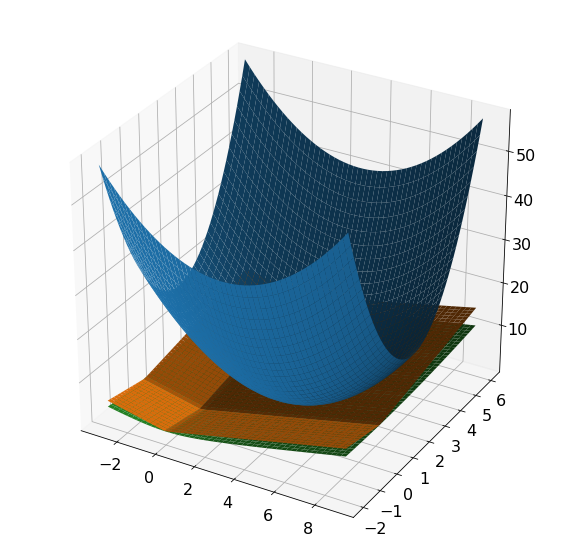

In [3]:
def loss_fn(W):
    return 0.5*(W[0]-3)**2 + 2.5*(W[1]-2)**2

# L1 regularization
def L1_regularization(W):
    return abs(W[0]) + abs(W[1])

def L2_regularization(W):
    return np.sqrt(W[0]**2 + W[1]**2)

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")

xmesh, ymesh = np.mgrid[-3:9:50j,-2:6:50j]
loss_mesh = loss_fn(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, loss_mesh);

l1_mesh = L1_regularization(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, l1_mesh);

l2_mesh = L2_regularization(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, l2_mesh);

## Plot the training progress

<br>
The diamond contour lines are the values of the L1 regularization.  Since this is a contour diagram, all the points on a contour line have the same L1 value.  <br>
In otherwords, for all points on a contour line:
$$L_1(W) = \left|w_0\right| + \left|w_1\right| == constant$$ 
This is called the L1-ball.<br>
L2-balls maintain the equation: $$L_2(W) = w_0^2 + w_1^2 == constant$$
<br>
The oval contour line are the values of the data loss function.  The regularized solution tries to find weights that satisfy both the data loss and the regularization loss. 
<br><br>
```alpha``` and ```beta``` control the strengh of the regularlization loss versus the data loss.
To see how the regularizers act "in the wild", set ```alpha``` and ```beta``` to a high value like 10.  The regularizers will then dominate the loss, and you will see how each of the regularizers acts.
<br>
Experiment with the value of alpha to see how it works.

solution: loss(3.000, 2.000)=0.000
solution: l1_loss(3.000, 2.000)=5.000
regularized solution: loss(2.250, 1.850)=0.337
regularized solution: l1_loss(2.250, 1.850)=4.100
regularized solution: l2_loss(1.200, 1.538)=3.807


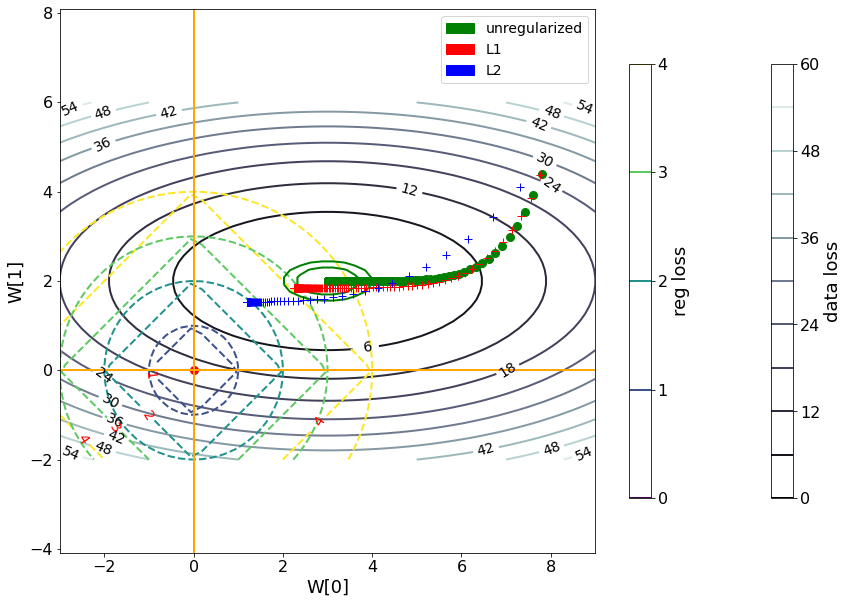

In [4]:
initial_guess = torch.Tensor([8,5]) 
W = Variable(initial_guess, requires_grad=True)
W_l1_reg = Variable(initial_guess.clone(), requires_grad=True) 
W_l2_reg = Variable(initial_guess.clone(), requires_grad=True) 

def L1_regularization(W):
    return W.norm(1)

def L2_regularization(W):
    return W.pow(2).sum()

lr = 0.04
alpha = 0.75 # 1.5 # 4 # 0.4
beta = 0.75
num_steps = 1000

def train(W, lr, alpha, beta, num_steps):
    guesses = []
    for i in range(num_steps):
        # Zero the gradients of the weights
        if W.grad is not None:
            W.grad.data.zero_()

        # Compute the loss and the gradients of W
        loss = loss_fn(W) + alpha * L1_regularization(W) + beta * L2_regularization(W)
        loss.backward()

        # Update W
        W.data = W.data - lr * W.grad.data
        guesses.append(W.data.numpy())
    return guesses

# Train the weights without regularization
guesses = train(W, lr, alpha=0, beta=0, num_steps=num_steps)
# ...and with L1 regularization
guesses_l1_reg = train(W_l1_reg, lr, alpha=alpha, beta=0, num_steps=num_steps)
guesses_l2_reg = train(W_l2_reg, lr, alpha=0,     beta=beta, num_steps=num_steps)


fig = plt.figure(figsize=(15,10))
plt.axis("equal")

# Draw the contour maps of the data-loss and regularization loss
CS = plt.contour(xmesh, ymesh, loss_mesh, 10, cmap=plt.cm.bone)
# Draw the L1-balls
CS2 = plt.contour(xmesh, ymesh, l1_mesh, 10, linestyles='dashed', levels=list(range(5)));
# Draw the L2-balls
CS3 = plt.contour(xmesh, ymesh, l2_mesh, 10, linestyles='dashed', levels=list(range(5)));

# Add green contour lines near the loss minimum
CS4 = plt.contour(CS, levels=[0.25, 0.5], colors='g')

# Place a green dot at the data loss minimum, and an orange dot at the origin
plt.scatter(3,2, color='g')
plt.scatter(0,0, color='r')

# Color bars and labels
plt.xlabel("W[0]")
plt.ylabel("W[1]")
CB  = plt.colorbar(CS, label="data loss", shrink=0.8, extend='both')
CB2 = plt.colorbar(CS2, label="reg loss", shrink=0.8, extend='both')
# Label the contour lines
plt.clabel(CS, fmt = '%2d', colors = 'k', fontsize=14) #contour line labels
plt.clabel(CS2, fmt = '%2d', colors = 'red', fontsize=14) #contour line labels

# Plot the two sets of weights (green are weights w/o regularization; red are L1; blue are L2)
it_array = np.array(guesses)
unregularized = plt.plot(it_array.T[0], it_array.T[1], "o", color='g')
it_array = np.array(guesses_l1_reg)
l1 = plt.plot(it_array.T[0], it_array.T[1], "+", color='r')
it_array = np.array(guesses_l2_reg)
l2 = plt.plot(it_array.T[0], it_array.T[1], "+", color='b')

# Legends require a proxy artists in this case
unregularized = mpatches.Patch(color='g', label='unregularized')
l1 = mpatches.Patch(color='r', label='L1')
l2 = mpatches.Patch(color='b', label='L2')
plt.legend(handles=[unregularized, l1, l2])

# Finally add the axes, so we can see how far we are from the sparse solution.
plt.axhline(0, color='orange')
plt.axvline(0, color='orange')

print("solution: loss(%.3f, %.3f)=%.3f" % (W.data[0], W.data[1], loss_fn(W)))
print("solution: l1_loss(%.3f, %.3f)=%.3f" % (W.data[0], W.data[1], L1_regularization(W)))
print("regularized solution: loss(%.3f, %.3f)=%.3f" % (W_l1_reg.data[0], W_l1_reg.data[1], loss_fn(W_l1_reg)))
print("regularized solution: l1_loss(%.3f, %.3f)=%.3f" % (W_l1_reg.data[0], W_l1_reg.data[1], L1_regularization(W_l1_reg)))
print("regularized solution: l2_loss(%.3f, %.3f)=%.3f" % (W_l2_reg.data[0], W_l2_reg.data[1], L2_regularization(W_l2_reg)))

## $L_1$-norm regularization leads to "near-sparsity"

$L_1$-norm regularization is often touted as sparsity inducing, but it actually creates solutions that oscillate around 0, not exactly 0 as we'd like. <br>
To demonstrate this, we redefine our toy loss function so that the optimal solution for $w_0$ is close to 0 (0.3).

In [5]:
def loss_fn(W):
    return 0.5*(W[0]-0.3)**2 + 2.5*(W[1]-2)**2

# Train again
W = Variable(initial_guess, requires_grad=True)
guesses_l1_reg = train(W, lr, alpha=alpha, beta=0, num_steps=num_steps)

When we draw the progress of the weight training, we see that $W_0$ is gravitating towards zero.<br>

Text(0, 0.5, 'W[1]')

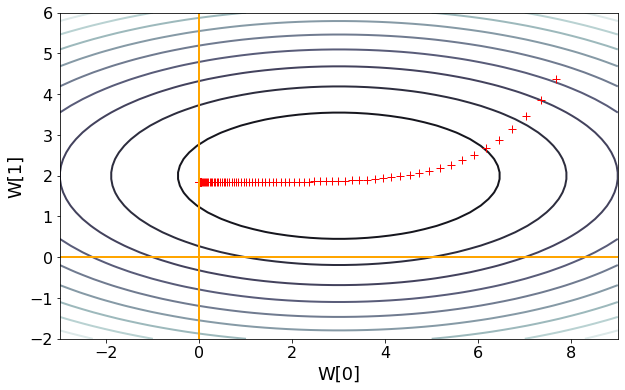

In [6]:
# Draw the contour maps of the data-loss and regularization loss
CS = plt.contour(xmesh, ymesh, loss_mesh, 10, cmap=plt.cm.bone)

# Plot the progress of the training process
it_array = np.array(guesses_l1_reg)
l1 = plt.plot(it_array.T[0], it_array.T[1], "+", color='r')

# Finally add the axes, so we can see how far we are from the sparse solution.
plt.axhline(0, color='orange')
plt.axvline(0, color='orange');
plt.xlabel("W[0]")
plt.ylabel("W[1]")

But if we look closer at what happens to $w_0$ in the last 100 steps of the training, we see that is oscillates around 0, but never quite lands there.  Why?<br>
Well, $dL1/dw_0$ is a constant (```lr * alpha``` in our case), so the weight update step:<br>
```W.data = W.data - lr * W.grad.data``` <br>
can be expanded to <br>
```W.data = W.data - lr * (alpha + dloss_fn(W)/dW0)``` where ```dloss_fn(W)/dW0)``` <br>is the gradient of loss_fn(W) with respect to $w_0$. <br>
The oscillations are not constant (although they do have a rythm) because they are influenced by this latter loss.

In [7]:
it_array = np.array(guesses_l1_reg[int(0.9*num_steps):])
for i in range(len(it_array)):
    print("%.4f\t(diff=%.4f)" % (it_array.T[0][i], abs(it_array.T[0][i]-it_array.T[0][i-1])))


-0.0067	(diff=0.0326)
0.0355	(diff=0.0423)
0.0161	(diff=0.0194)
-0.0025	(diff=0.0186)
0.0396	(diff=0.0421)
0.0200	(diff=0.0196)
0.0012	(diff=0.0188)
-0.0169	(diff=0.0180)
0.0258	(diff=0.0427)
0.0068	(diff=0.0190)
-0.0115	(diff=0.0183)
0.0310	(diff=0.0425)
0.0117	(diff=0.0192)
-0.0067	(diff=0.0185)
0.0355	(diff=0.0423)
0.0161	(diff=0.0194)
-0.0025	(diff=0.0186)
0.0396	(diff=0.0421)
0.0200	(diff=0.0196)
0.0012	(diff=0.0188)
-0.0169	(diff=0.0180)
0.0258	(diff=0.0427)
0.0068	(diff=0.0190)
-0.0115	(diff=0.0183)
0.0310	(diff=0.0425)
0.0117	(diff=0.0192)
-0.0067	(diff=0.0185)
0.0355	(diff=0.0423)
0.0161	(diff=0.0194)
-0.0025	(diff=0.0186)
0.0396	(diff=0.0421)
0.0200	(diff=0.0196)
0.0012	(diff=0.0188)
-0.0169	(diff=0.0180)
0.0258	(diff=0.0427)
0.0068	(diff=0.0190)
-0.0115	(diff=0.0183)
0.0310	(diff=0.0425)
0.0117	(diff=0.0192)
-0.0067	(diff=0.0185)
0.0355	(diff=0.0423)
0.0161	(diff=0.0194)
-0.0025	(diff=0.0186)
0.0396	(diff=0.0421)
0.0200	(diff=0.0196)
0.0012	(diff=0.0188)
-0.0169	(diff=0.0180

## References

<div id="Goodfellow-et-al-2016"></div> **Ian Goodfellow and Yoshua Bengio and Aaron Courville**. 
    [*Deep Learning*](http://www.deeplearningbook.org),
    MIT Press,
    2016.